In [13]:
"""
Task:
given a trajectory with each waypoint being joint angles, determine the veloctiy, time and acceleration.

Input:
x_0, x_1, ..., x_N
v_0

Output:
v_0, v_1, ..., v_N
t_0, t_1, ..., t_N
a_0, a_1, ..., a_N
"""

# here we try using spline interpolation to solve the task
# since each segment can be uniquely determined by:
# (t_0, x_0, v_0, t_1, x_1, v_1)
# by setting v_0 and v_1 to be max values, and modifying t_0 and t_1,
# we can probably find good values
# cubic spline: assume the model as:
# x(t) = A + Bt + Ct^2 + Dt^3
import numpy as np
import scipy as sy

# define limits
v_max = 10 * np.pi / 180
a_max = 100 * np.pi / 180


# first try one segment
x0 = np.random.random() * 2*np.pi - np.pi
x1 = np.random.random() * 2*np.pi - np.pi
x2 = np.random.random() * 2*np.pi - np.pi
v0 = np.zeros(1)
# based on x0 and x2, determine v1
if x0 < x1 and x1 < x2:
    v1 = v_max
elif x0 > x1 and x1 > x2:
    v1 = -v_max
else:
    v1 = 0.
v2 = 0.

# fit the spline
# equation:
# x0 = A
# x1 = A + Bt + Ct^2 + Dt^3
# v0 = B
# v1 = B + 2Ct + 3Dt^2
# a = 2C + 6Dt

# => C = 1/t^2 (3x1 - tv1 - 3A - 2Bt)
# conceptually, extend the line horizontally should make the derivative smaller
def cubic_track_seg(x0, v0, x1, v1):
    t = 1.0
    while True:
        A = x0
        B = v0
        C = (1/(t**2)) * (3*x1 - t*v1 - 3*A - 2*B*t)
        D = (v1 - B - 2*C*t) / 3 / (t*t)
        a0 = 2*C
        a1 = 2*C + 6*D*t
#         print('a_max: ')
#         print(a_max)
#         print('a0: ')
#         print(a0)
#         print('a1: ')
#         print(a1)
        if np.abs(a0).max() > a_max or np.abs(a1).max() > a_max:
            t = t * 1.5
        else:
            break
        print('a0: ')
        print(a0)
        print('a1: ')
        print(a1)
    assert np.linalg.norm(A - x0) < 1e-4
    assert np.linalg.norm(B - v0) < 1e-4
    assert np.linalg.norm(A + B*t + C*t*t + D*t*t*t - x1) < 1e-4
    assert np.linalg.norm(B + 2*C*t + 3*D*t*t - v1) < 1e-4

    return t, A, B, C, D

def cubic_track_traj(pos_traj, v0):
    # scan the entire trajectory to define the values for each velocity
    vel_traj = []
    vel_traj.append(v0)
    time_traj = [0.]
    As = []
    Bs = []
    Cs = []
    Ds = []
    for i in range(1, len(pos_traj)-1):
        # compare with neighbor values, determine the current value
        v = np.zeros(v0.shape)
        v[(pos_traj[i] > pos_traj[i-1]) & (pos_traj[i+1] > pos_traj[i])] = v_max
        v[(pos_traj[i] < pos_traj[i-1]) & (pos_traj[i+1] < pos_traj[i])] = -v_max
        vel_traj.append(v)
    vel_traj.append(np.zeros(v0.shape))
    # determine the durations
    for i in range(len(pos_traj)-1):
        t, A, B, C, D = cubic_track_seg(pos_traj[i], vel_traj[i], pos_traj[i+1], vel_traj[i+1])
        time_traj.append(time_traj[-1]+t)
        As.append(A)
        Bs.append(B)
        Cs.append(C)
        Ds.append(D)
    return vel_traj, time_traj, As, Bs, Cs, Ds
    

a0: 
[ 6.25656327 23.33853382]
a1: 
[ -5.90749742 -23.68759967]
a0: 
[ 2.7031246  10.21754132]
a1: 
[ -2.47041403 -10.45025189]
a0: 
[1.14967525 4.43770256]
a1: 
[-0.99453487 -4.59284293]
a0: 
[0.47649114 1.90336097]
a1: 
[-0.37306422 -2.00678789]
a0: 
[ 7.2317132  -2.77492853]
a1: 
[-7.2317132   2.42586267]
a0: 
[ 2.98138419 -1.15573138]
a1: 
[-2.98138419  0.92302081]
a0: 
[14.34713206 -6.45775062]
a1: 
[-14.69619791   6.45775062]
a0: 
[ 6.22136276 -2.63740082]
a1: 
[-6.45407333  2.63740082]
a0: 
[ 2.6616232  -1.01703776]
a1: 
[-2.81676357  1.01703776]
a0: 
[-32.60763847  -1.30107675]
a1: 
[32.60763847  1.30107675]
a0: 
[-14.49228377  -0.34554577]
a1: 
[14.49228377  0.34554577]
a0: 
[-6.44101501e+00  1.56448091e-03]
a1: 
[ 6.44101501e+00 -1.56448091e-03]
a0: 
[-2.86267334  0.10412224]
a1: 
[ 2.86267334 -0.10412224]
a0: 
[13.50227534  0.51970374]
a1: 
[-13.50227534  -0.17063789]
a0: 
[6.00101126 0.38611982]
a1: 
[-6.00101126 -0.15340925]
a0: 
[2.66711612 0.27503573]
a1: 
[-2.66711612 -

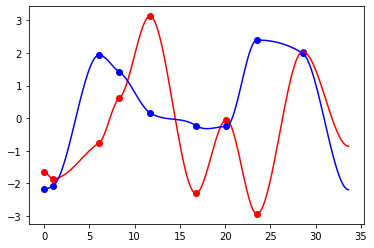

In [23]:
# randomly create a bunch of waypoints
import matplotlib.pyplot as plt
pos_traj = np.random.random((10, 2)) * np.pi * 2 - np.pi
v0 = np.zeros(2)
vel_traj, time_traj, As, Bs, Cs, Ds = cubic_track_traj(pos_traj, v0)
colors = ['red', 'blue']
for i in range(len(pos_traj)-1):
    # plot segment: x = A + B(t-time_traj[i]) + C(t-time_traj[i])^2 + D(t-time_traj[i])^3
    ts = np.linspace(time_traj[i], time_traj[i+1], 100)
    print(ts-time_traj[i])
    for j in range(len(As[i])):
        pos = As[i][j] + Bs[i][j] * (ts-time_traj[i]) + Cs[i][j] * ((ts-time_traj[i])**2) + Ds[i][j] * ((ts-time_traj[i])**3)
        plt.plot(ts, pos, c=colors[j])
        plt.scatter([time_traj[i]],[pos_traj[i][j]], c=colors[j])
#         print('joint %d' % (j))
#         print(pos_traj[i+1][j])
#         print(pos[-1])
plt.show()